# 由二分类推广到多分类

二分类交叉熵损失可以被推广到多分类上，但在实际处理时，二分类与多分类却有些关键的区别。依然使用极大似然估计的推导流程，首先我们来确定“单一样本被预测正确”这一事件的概率最大化后的似然函数。

对于多分类的状况而言，标签不再服从伯努利分布 (0-1分布)，因此我们可以定义，样本i在由特征向量x;和权重向量w组成的预测函数中，样本标签被预测为类别k的概率为:

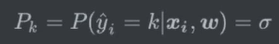

对于多分类算法而言，σ就是softmax函数返回的对应类别的值

假设一种最简单的情况: 我们现在有三分类[1,2,3]，则样本 i 被预测为三个类别的概率分别为:

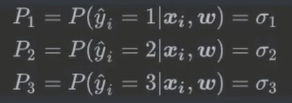

假设样本的真实标签为1，我们就希望B最大，同理，如果样本的真实标签为其他值，我们就希望其他值所对应的概率最大。在二分类中，我们将y和(1-y)作为概率P的指数，以此来融合真实标签为0和为1的两种状况。但在多分类中，我们的真实标签可能是任意整数，无法使用y和(1 - )这样的结构来构建似然函数。所以我们认为，如果多分类的标签也可以使用0和1来表示就好了，这样我们就可以继续使用真实标签作为指数的方式。

因此，我们对多分类的标签做出了如下变化: 读热编码（做哑变量）

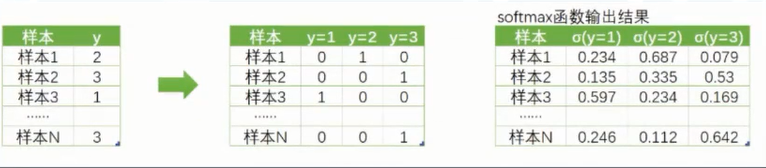

当我们把标签整合为标签矩阵后，我们就可以将单个样本在总共K个分类情况整合为以下的似然函数:

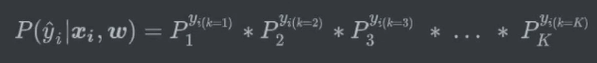

更具体的，小k代表y的真实取值，K代表总共有K个分类(此处不是非常严谨，按道理说若K代表总共有K个类别，则不应该再使用K代表某个具体类别，但在这里，由于我们使用的类别编号与类别本身相同，所以为了公式的简化，使用了这样不严谨的表示方式)。虽然是连乘，但对于一个样本，除了自己所在的真实类别指数yi会是1之外，其他类别的指数都为0，所以被分类为其他类别的概率在这个式子里就都为0。所以我们可以将式子简写为:

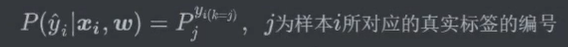

对一个训练集的m个样本来说，我们可以定义如下等式来表达所有样本在特征张量X和权重向量w组成的预测函数中，预测出所有可能的g的概率P为:

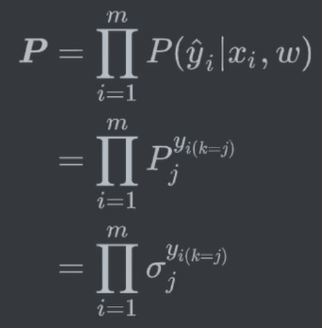

这就是多分类状况下的似然函数。与二分类一致，似然函数解出来后，我们需要对似然函数求对数

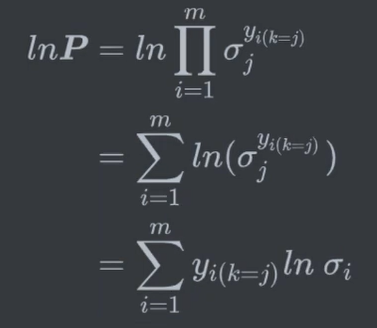

其中σ就是softmax函数返回的对应类别的值。再对整个公式取负，就得到了多分类状况下的损失函数

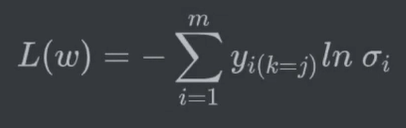

这个函数就是我们之前提到过的交叉熵函数。不难看出，二分类的交叉熵函数其实是多分类的一种特殊情况。

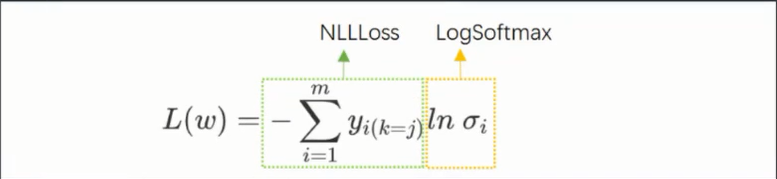

交叉函数十分特殊，虽然我们求解过程中，取对数的操作是在确定了似然函数后才进行的，但从计算结果来看，对数操作其实只对softmax函数的结果o起效。因此在实际操作中，我们把In(softmax(z))这样的函数单独定义了一个功能做logsoftmax，PyTorch中可以直接通过nnlogsoftmax类调用这个功能。同时，我们把对数之外的，乘以标签、加和、取负等等过程打包起来，称之为负对数似然函数 (Negative Log Likelihoodfunction)，在PyTorch中可以使用nn.NLLLoss来进行调用。<b>也就是说，在计算损失函数时，我们不再需要使用单独的softmax函数了

# 用PyTorch实现多分类交叉熵损失函数 

在PyTorch中实现交叉熵函数的时候，有两种办法：

<li> 依此调用logsoftmax和NLLLoss实现

In [4]:
import torch
import torch.nn as nn

In [5]:
# loss = -(y * ln(sigma) + (1-y)*ln(1-sigma))

# y - 真实标签
# sigma - 预测概率 [sigmoid(z)结果]
# z = Xw
# X , w
# m - 样本量

In [27]:
m = 3 * pow(10,3)

torch.random.manual_seed(420)
X = torch.rand((m,4),dtype = torch.float32)
w = torch.rand((4,3),dtype = torch.float32)
y = torch.randint(low = 0,high = 3,size = (m,),dtype = torch.float32)

In [28]:
zhat = torch.mm(X,w)
# sigma = torch.softmax(zhat)

# logsoftmax = log + softmax 输入：zhat
# NLLLoss()
logsm = nn.LogSoftmax(dim = 1)
logsigma = logsm(zhat)
criterion = nn.NLLLoss()
criterion(logsigma,y.long())

tensor(1.1147)

<li> 直接调用CrossEntropyLoss

In [29]:
criterion = nn.CrossEntropyLoss()
criterion(zhat,y.long())

tensor(1.1147)

    注： NLLLoss 以及 CrossEntropyLoss 中都有reduction参数
    reduction = "mean"/"sum"/"None" 均值，整体，矩阵

无论时二分类还是多分类，PyTorch都提供了包含输出层激活函数和不包含输出层激活函数的类两种选择。在实际神经网络建模中，类可以被放入定义好的Model类中去构建神经网络的结构，因此是否包含激活函数，就需要由用户来自行选择。

<li>重视展示网络结构和灵活性，应该使用不包含输出层激活函数的类

通常在Model类中，init 中层的数量与forward函数中对应的激活函数的数量是一致的，如果我们使用内置sigmoid/logsoftmax功能的类来计算损失函数，forward函数在定义时就会少一层 (输出层)网络结构展示就不够简单明了，对于结构复杂的网络而言，结构清晰就更为重要。同时，如果激活函数是单独写的，要修改激活函数就变得很容易，如果混在损失函数中，要修改激活函数时就得改掉整个损失函数的代码，不利于维护

<li>重视稳定性和运算精度，使用包含输出层激活函数的类

如果在一个Model中，很长时间我们都不会修改输出层的激活函数并且模型的稳定运行更为要紧，我们就使用内置了激活函数的类来计算损失函数。同时，就像之前提到的，内置激活函数可以帮助我们推升运算的精度